# Calibration of the flooding model with gaussian linear least squares (BLUE)

### Objectifs
* Prédire la hauteur de l'eau H en fonction du débit Q

### Entrées
On considère les quatre variables suivantes : 
* Q : le débit de la rivière ($m^3/s$)
* Ks : le coefficient de Strickler ($m^{1/3}/s$)
* Zv : la côte du fond de la rivière en aval (m)
* Zm : la côte du fond de la rivière en amont (m)

### Notes : 
* Quand Ks augmente, le fond de la rivière oppose moins de frottement à l'écoulement de l'eau.
* On fait l'hypothèse que les variables sont statistiquement indépendantes.

### Paramètres

On considère les valeurs suivantes des paramètres :
* la longueur du tronçon de rivière L = 5000 (m),
* la largeur de la rivière B = 300 (m).

### Sortie

La pente de la rivière est supposée proche de zéro, ce qui implique :
$$
\alpha = \frac{Z_m - Z_v}{L},
$$
si $Z_m \geq Z_v$. 
La hauteur de l'eau est modélisée par :
$$
H = \left(\frac{Q}{K_s B \sqrt{\alpha}}\right)^{0.6},
$$
pour tous $K_s, Q>0$.

<img src="river_section_adjusted_light.png" width="400" />

### Lois de distribution

On fait l'hypothèse que le débit suit la loi de Gumbel tronquée suivante :

|Variable|Distribution|
| ------------- |-------------|
|Q|Gumbel(scale=558, mode=1013)>0|

### Paramètres à identifier

Les variables $(Kz,Zv,Zm)$ à caler sont les suivantes :
$$
Ks = 30, \qquad Zv = 50, \qquad Zm = 55.
$$

### Observations

Les hauteurs d'eau observées sont entachées d'un bruit d'observation de moyenne nulle et d'écart-type
$$
\sigma=0.1.
$$
Les hauteurs d'eau observées sont 
$$
H_i = G(Q_i,Ks,Zv,Zm) + \epsilon
$$
pour $i=1,...,n$ où 
$$
\epsilon \sim \mathcal{N}(0,\sigma^2).
$$
On considère un échantillon de taille 
$$
n=100.
$$
Les observations sont des couples $(Q,H)$.

### Analyse

Dans ce modèle, les variables $Z_m$ et $Z_v$ ne sont pas identifiables, puisque seule la différence $Z_m-Z_v$ importe.

In [1]:
import pylab as pl
import openturns as ot
from math import sqrt
import numpy as np
from openturns.viewer import View

## Définition du modèle

On commence par charger les données : il y a 100 observations du couple (Q,H).

In [2]:
observedSample = ot.Sample_ImportFromCSVFile("calage-KS-observations.csv")
nbobs = observedSample.getSize()
Qobs = observedSample[:,0]
Hobs = observedSample[:,1]
nbobs

100

In [3]:
Hobs.setDescription(["Hauteur (m)"])

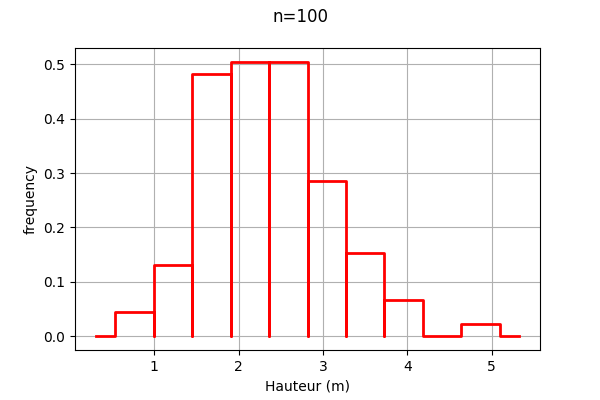

In [4]:
graph = ot.VisualTest_DrawHistogram(Hobs)
graph.setXTitle("Hauteur (m)")
graph.setTitle("n=%s" % (nbobs))
graph.setLegends([""])
graph

Puis on définit la fonction crue, qui possède 4 entrées Q, Ks, Zv, Zm et une sortie H.

In [5]:
def functionCrueModel(X):
    Q, K_s, Z_v, Z_m = X
    L = 5.0e3
    B = 300.0
    alpha = (Z_m - Z_v)/L
    H = (Q/(K_s*B*sqrt(alpha)))**(3.0/5.0)
    return [H]

In [6]:
modelPyFunc = ot.PythonFunction(4, 1, functionCrueModel)
modelPyFunc.setDescription(["Q", "Ks", "Zv", "Zm","H"])

Les lignes suivantes créent la fonction de calage à partir de la fonction modèle :
* les entrées X sont à l'indice 0,
* les variables de calage sont aux indices 1, 2, 3,
* les observations sont données dans `Qobs`.

In [7]:
KsInitial = 20.
ZvInitial = 49.
ZmInitial = 51.
thetaBackground = ot.Point([KsInitial,ZvInitial,ZmInitial])

The standard deviation of the observations.

In [8]:
sigmaH = 0.5 # (m^2)

In [9]:
errorCovariance = ot.CovarianceMatrix(1)
errorCovariance[0,0] = sigmaH**2

In [10]:
calibratedIndices = [1,2,3]
mycf = ot.ParametricFunction(modelPyFunc, calibratedIndices, thetaBackground)
mycf(Qobs[0])

class=Point name=Unnamed dimension=1 values=[3.58481]

In [11]:
sigmaKs = 5.
sigmaZv = 1.
sigmaZm = 1.

In [12]:
sigma = ot.CovarianceMatrix(3)
sigma[0,0] = sigmaKs**2
sigma[1,1] = sigmaZv**2
sigma[2,2] = sigmaZm**2
sigma

class=CovarianceMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[25,0,0,0,1,0,0,0,1]

In [13]:
algo = ot.BLUE(mycf, Qobs, Hobs, thetaBackground, sigma, errorCovariance,"SVD")

In [14]:
algo.run()

In [15]:
calibrationResult = algo.getResult()

In [16]:
thetaStar = calibrationResult.getParameterMAP()
thetaStar

class=Point name=Unnamed dimension=3 values=[24.5037,48.0993,51.9007]

In [17]:
import CalibrationGraphics

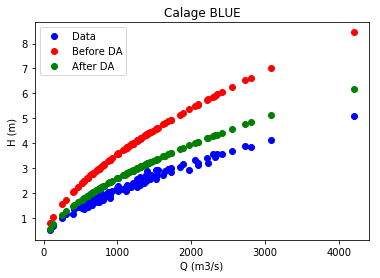

In [18]:
pl.xlabel("Q (m3/s)")
pl.ylabel("H (m)")
pl.title("Calage BLUE")
CalibrationGraphics.plotModelVsDataBeforeAndAFter(thetaBackground,thetaStar,Qobs,Hobs,mycf)

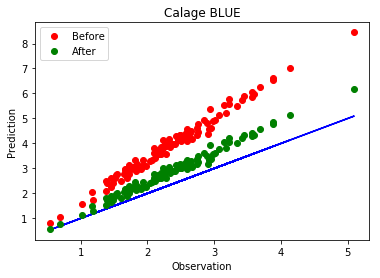

In [19]:
pl.title("Calage BLUE")
CalibrationGraphics.plotObservationsVsPredictionsBeforeAfter(thetaBackground,thetaStar,Qobs,Hobs,mycf)

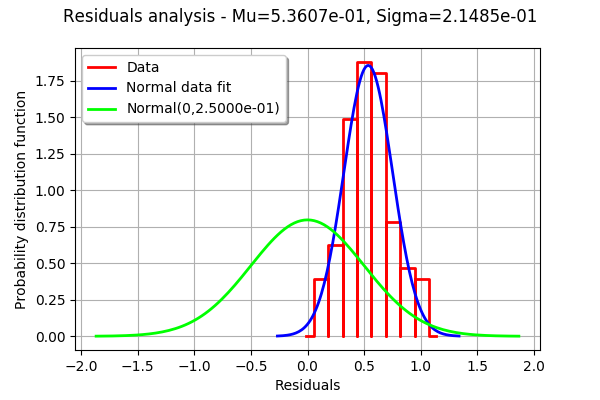

In [20]:
graph = CalibrationGraphics.plotResiduals(thetaStar,Qobs,Hobs,mycf,errorCovariance)
graph.setLegendPosition("topleft")
graph

In [21]:
labelsTheta = ("Ks (m^(1/3)/s)","Zv (m)","Zm (m)")

In [22]:
distributionPosterior = calibrationResult.getParameterPosterior()
distributionPosterior

class=Normal name=Normal dimension=3 mean=class=Point name=Unnamed dimension=3 values=[24.5037,48.0993,51.9007] sigma=class=Point name=Unnamed dimension=3 values=[4.08465,0.816931,0.816931] correlationMatrix=class=CorrelationMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[1,0.498407,-0.498407,0.498407,1,0.498407,-0.498407,0.498407,1]

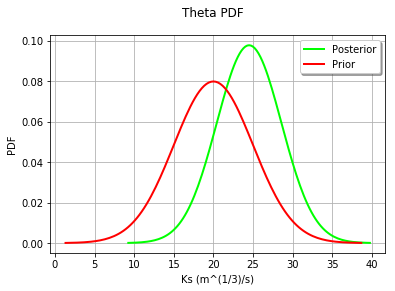

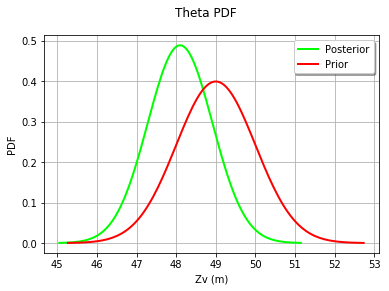

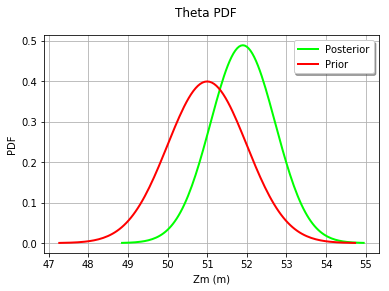

In [23]:
CalibrationGraphics.plotThetaDistribution(thetaBackground,thetaStar,sigma,distributionPosterior,labelsTheta)